In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline

In [2]:
# 2.1
ways = np.array([0,3,8,9,0])
ways/np.sum(ways)

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

In [9]:
# 2.2
stats.binom.pmf(k=6, n=9, p=0.5)

0.16406250000000006

In [27]:
stats.binom.pmf(k=6,n=9,p=0.6666666666666666)

0.2731290961743636

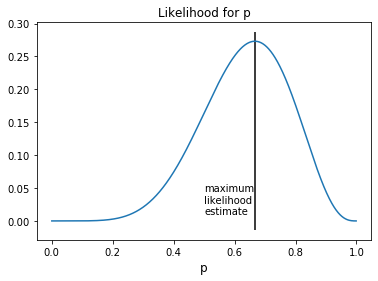

In [56]:
# 2.2 extended
list_of_p = np.arange(0,1,0.001)
fig, ax = plt.subplots(1,1)
plt.plot(list_of_p, stats.binom.pmf(k=6, n=9, p=list_of_p))
plt.vlines(x=6/9, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
plt.text(0.5, 0.01, "maximum\nlikelihood\nestimate")
plt.xlabel("p", fontsize=12)
plt.title("Likelihood for p")
pass

In [59]:
# 2.3
# define grid
p_grid = np.linspace(0, 1, 20)

# define uninformative prior
prior = np.ones((20))

# compute likelihood at each value in grid
likelihood = stats.binom.pmf(k=6, n=9, p=p_grid)

# compute product of likelihood and prior
unstd_posterior = prior * likelihood

# standardize the posterior, so it sums to 1
std_posterior = unstd_posterior/unstd_posterior.sum()

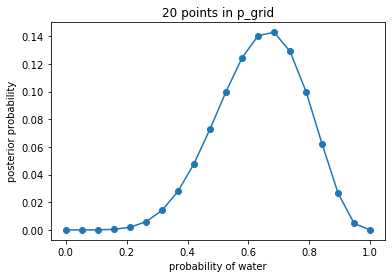

In [65]:
# 2.4
plt.plot(p_grid, std_posterior, 'o-')
plt.xlabel('probability of water')
plt.ylabel('posterior probability')
plt.title('20 points in p_grid')
pass

### Grid Approximation

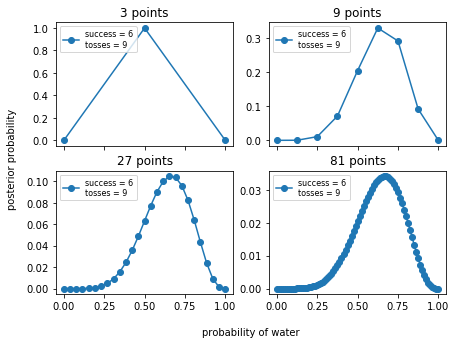

In [120]:
# Combining 2.3, 2.4, and 2.5
w, t = 6, 9

def generate_posterior(n, success=6, tosses=9, prior_type='uninformative'):
    '''Args:
           n: int > 1, number of points used in grid
           prior_type: str, 'uninformative', 'cutoff_05', 'exp'
       Returns:
           a tuple for probability grid and matching posteriors
    '''
    p_grid = np.linspace(0, 1, n)
    if prior_type == 'uninformative':
        prior = np.ones((n))
    elif prior_type == 'cutoff_05':
        prior = (p_grid >= 0.5).astype(int)
    elif prior_type == 'exp':
        prior = np.exp(-5*np.abs(p_grid-0.5))
    likelihood = stats.binom.pmf(k=success, n=tosses, p=p_grid)
    unstd_posterior = prior * likelihood
    std_posterior = unstd_posterior/unstd_posterior.sum()
    
    return p_grid, std_posterior

fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, 
                         squeeze=False, figsize=(7,5))
axes_flat = axes.flatten()
for i, n in enumerate([3, 9, 3**3, 3**4]):
    p_grid, std_posterior = generate_posterior(n)
    cax = axes_flat[i]
    cax.plot(p_grid, std_posterior, 'o-', label=f"success = {w}\ntosses = {t}")
    cax.set(title=f'{n} points')
    cax.legend(loc=2, fontsize=8)
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\nprobability of water')
plt.ylabel('posterior probability\n')
pass

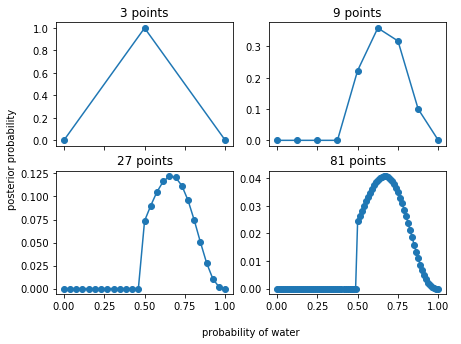

In [111]:
# 2.5 changing prior with cutoff at 0.5
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, 
                         squeeze=False, figsize=(7,5))
axes_flat = axes.flatten()
for i, n in enumerate([3, 9, 3**3, 3**4]):
    p_grid, std_posterior = generate_posterior(n, prior_type='cutoff_05')
    cax = axes_flat[i]
    cax.plot(p_grid, std_posterior, 'o-')
    cax.set(title='{} points'.format(n))
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\nprobability of water')
plt.ylabel('posterior probability\n')
pass

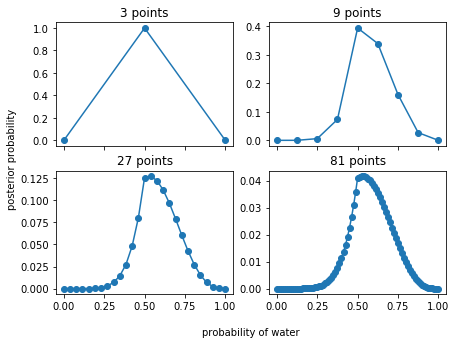

In [112]:
# 2.5 changing prior to exponential
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, 
                         squeeze=False, figsize=(7,5))
axes_flat = axes.flatten()
for i, n in enumerate([3, 9, 3**3, 3**4]):
    p_grid, std_posterior = generate_posterior(n, prior_type='exp')
    cax = axes_flat[i]
    cax.plot(p_grid, std_posterior, 'o-')
    cax.set(title='{} points'.format(n))
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\nprobability of water')
plt.ylabel('posterior probability\n')
pass

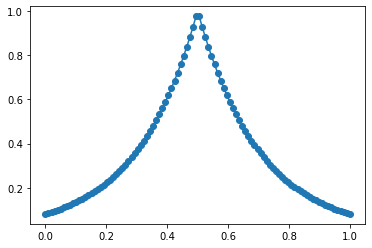

In [109]:
# 2.5 understand exp prior
p_grid = np.linspace(0, 1, 100)
prior = np.exp(-5*np.abs(p_grid-0.5))
plt.plot(p_grid, prior,'o-')

### Quadratic Approximation

In [2]:
# import multiprocessing as mp
# mp.set_start_method("fork")
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [3]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_aproximation:
    p = pm.Uniform("p", 0, 1)
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]
mean_q["p"], std_q

logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 443.91it/s]


(array(0.66666667), array([0.15713484]))

In [26]:
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2]) # 0.055, 0.945
pi = mean_q["p"] + std_q * z
pi

array([0.41553484, 0.91779849])

### Analytical Approximation

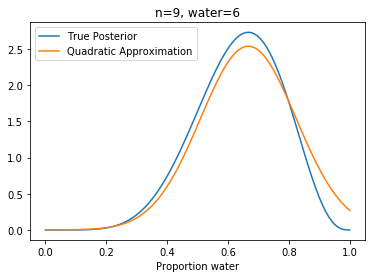

In [28]:
# 2.7
# analytical calculation
# posterior for binomial with uniform prior follows beta distribution 
# with a = successes + 1 and b = losses + 1
w, n = 6, 9
x = np.linspace(0,1,100)
plt.plot(x, stats.beta.pdf(x, w+1, n-w+1), label='True Posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label = "Quadratic Approximation")

plt.legend(loc=0)
plt.title(f"n={n}, water={w}")
plt.xlabel("Proportion water")
pass

### MCMC

In [64]:
# 2.8
np.random.seed(23)
n_samples = 500
p = np.repeat(np.nan, n_samples)
p[0] = 0.5
w, n = 6, 9
for idx in range(1, n_samples):
    p_new = np.random.normal(loc=p[idx-1], scale=0.1)
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    q_prev = stats.binom.pmf(w, n, p[idx-1])
    q_curr = stats.binom.pmf(w, n, p_new)
    
    p[idx] = p_new if q_curr/q_prev > np.random.uniform() else p[idx-1]


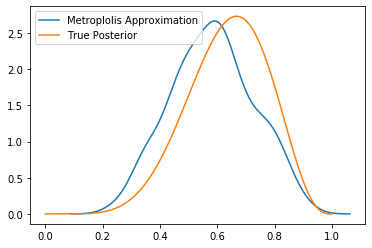

In [65]:
x = np.linspace(0,1,n_samples)

_, ax = plt.subplots(1,1)
sns.kdeplot(p, ax=ax, label = 'Metroplolis Approximation')

plt.plot(x, stats.beta.pdf(x, w+1, n-w+1), "C1", label='True Posterior')
plt.legend()